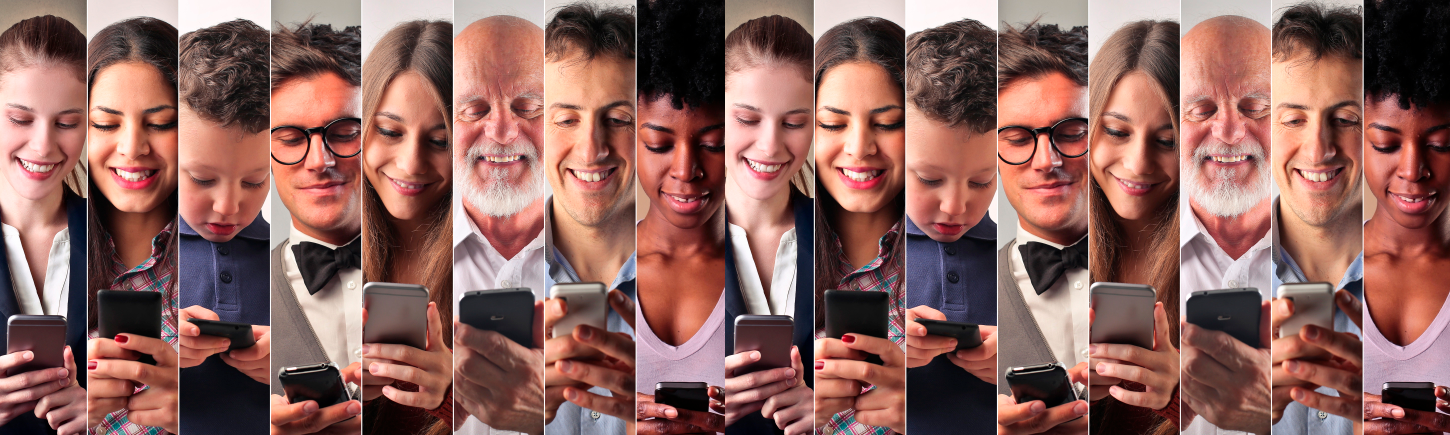

# Рекомендация тарифов

Оператор мобильной связи выяснил: многие клиенты пользуются архивными тарифами.\
Требуется построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Необходимо сделать модель для задачи классификации, которая выберет подходящий тариф с максимально большим значением accuracy (>0.75).

**Описание данных**<br>
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.\
`сalls` — количество звонков,\
`minutes` — суммарная длительность звонков в минутах,\
`messages` — количество sms-сообщений,\
`mb_used` — израсходованный интернет-трафик в Мб,\
`is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

**Ход работы:** <br>
1. анализ данных;
2. разбивка данных на выборки;
3. исследование моделей;
4. проверка моделей на тестовой выборке;
5. проверка моделей на адекватность.

## Анализ данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
import random

In [2]:
# создаём df с учётом возможных трёх локаций исходного датасета 
try:
    data = pd.read_csv('../../06 введение в машинное обучение/project/users_behavior.csv')
except:
    try:
        data = pd.read_csv('/datasets/users_behavior.csv')
    except:
        data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [3]:
data.head()  # первые 5 строк df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
data.info()  # общая информация о df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
data[['calls','messages']] = data[['calls','messages']].astype(int) # перевод признаков 'calls' и 'messages' в тип int

In [6]:
# описание признаков с разбивкой на тарифы
description = data.query('is_ultra==0').describe().join(
              data.query('is_ultra==1').describe(), lsuffix='_S', rsuffix='_U').\
              reindex(columns=['calls_S','calls_U','minutes_S','minutes_U','messages_S',
                               'messages_U','mb_used_S','mb_used_U','is_ultra_S','is_ultra_U']).astype(int)
description

,calls_S,calls_U,minutes_S,minutes_U,messages_S,messages_U,mb_used_S,mb_used_U,is_ultra_S,is_ultra_U
count,2229,985,2229,985,2229,985,2229,985,2229,985
mean,58,73,405,511,33,49,16208,19468,0,1
std,25,43,184,308,28,47,5870,10087,0,0
min,0,0,0,0,0,0,0,0,0,1
25%,40,41,274,276,10,6,12643,11770,0,1
50%,60,74,410,502,28,38,16506,19308,0,1
75%,76,104,529,730,51,79,20043,26837,0,1
max,198,244,1390,1632,143,224,38552,49745,0,1


In [7]:
# соотношение характеристик признаков тарифа Ультра к Смарт (Ультра-характеристика/Смарт-хар.)
ratio_U_to_S = pd.DataFrame(index=description.index)
for i in range(0,9,2):
    ratio_U_to_S = ratio_U_to_S.join(pd.DataFrame(description.iloc[:,i+1]/description.iloc[:,i],
                                                  columns=[description.iloc[:,i].name[:-2]]))
ratio_U_to_S.drop(columns='is_ultra', index=['count','min','25%','75%']).style.format('{:.2f}').background_gradient()

,calls,minutes,messages,mb_used
mean,1.26,1.26,1.48,1.20
std,1.72,1.67,1.68,1.72
50%,1.23,1.22,1.36,1.17
max,1.23,1.17,1.57,1.29


### Графики

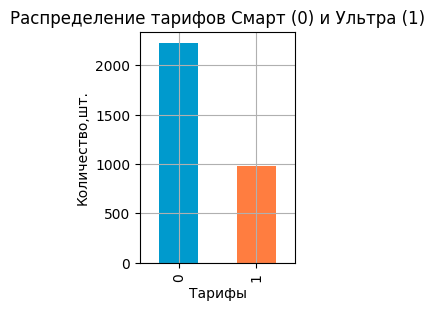

In [8]:
data['is_ultra'].value_counts().plot(kind='bar',grid=True,figsize=(2,3),title='Распределение тарифов Смарт (0) и Ультра (1)', 
                                     xlabel='Тарифы', ylabel='Количество,шт.',color=('#009ACD','#FF7D40')); plt.show()

#### количество звонков

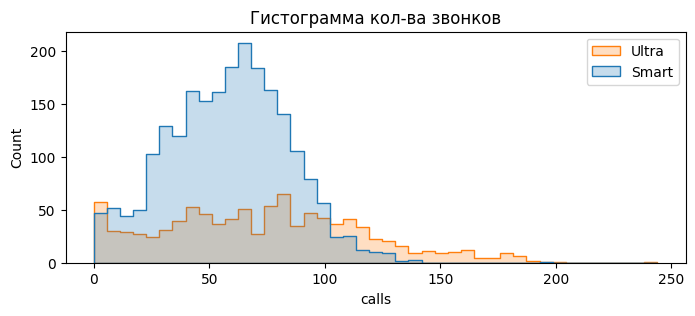

In [9]:
plt.figure(figsize=(8,3))
sns.histplot(data,x='calls',hue='is_ultra',element='step')
plt.title('Гистограмма кол-ва звонков'); plt.legend(['Ultra','Smart']); plt.show()

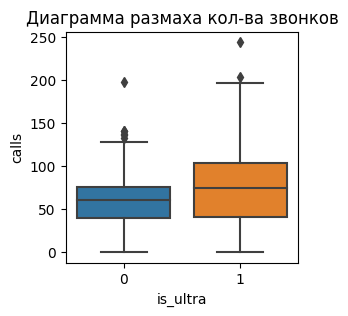

In [10]:
plt.figure(figsize=(3,3))
sns.boxplot(data=data,y='calls',x='is_ultra')
plt.title('Диаграмма размаха кол-ва звонков'); plt.show()

#### суммарная длительность звонков в минутах

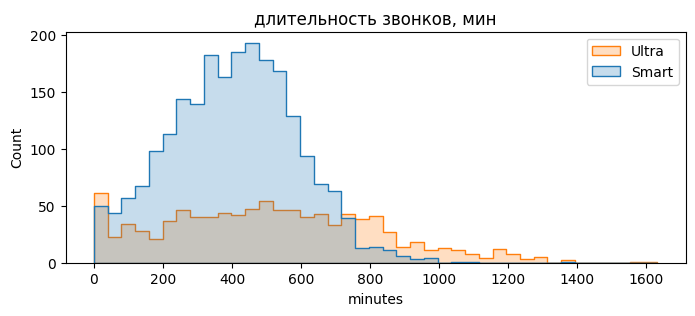

In [11]:
plt.figure(figsize=(8,3))
sns.histplot(data,x='minutes',hue='is_ultra',element='step')
plt.title('длительность звонков, мин'); plt.legend(['Ultra','Smart']); plt.show()

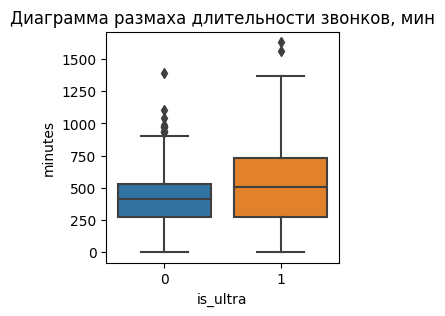

In [12]:
plt.figure(figsize=(3,3))
sns.boxplot(data=data,y='minutes',x='is_ultra')
plt.title('Диаграмма размаха длительности звонков, мин'); plt.show()

#### кол-во СМС сообщений

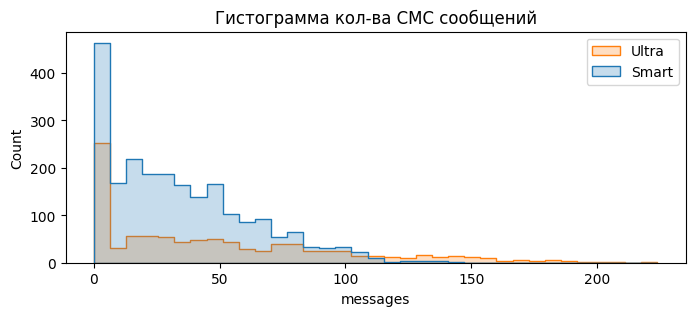

In [13]:
plt.figure(figsize=(8,3))
sns.histplot(data,x='messages',hue='is_ultra',element='step')
plt.title('Гистограмма кол-ва СМС сообщений'); plt.legend(['Ultra','Smart']); plt.show()

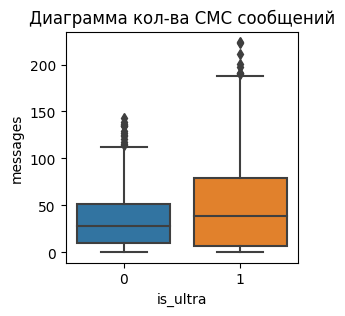

In [14]:
plt.figure(figsize=(3,3))
sns.boxplot(data=data,y='messages',x='is_ultra')
plt.title('Диаграмма кол-ва СМС сообщений'); plt.show()

#### израсходованный интернет-трафик в Мб

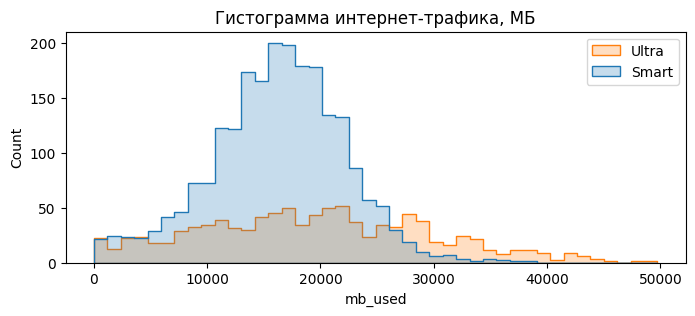

In [15]:
plt.figure(figsize=(8,3))
sns.histplot(data,x='mb_used',hue='is_ultra',element='step')
plt.title('Гистограмма интернет-трафика, МБ'); plt.legend(['Ultra','Smart']); plt.show()

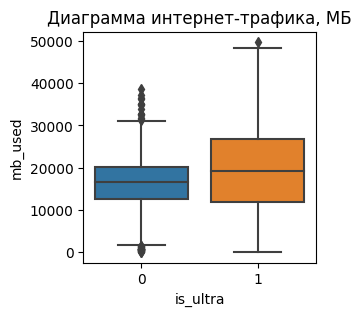

In [16]:
plt.figure(figsize=(3,3))
sns.boxplot(data=data,y='mb_used',x='is_ultra')
plt.title('Диаграмма интернет-трафика, МБ'); plt.show()

Абонентов с тарифом Смарт в 2.3 раза больше, чем абонентов с тарифом Ультра.\
Все представленные выше гистограммы и диаграммы размаха показывают: 
- меньшее число значений у тарифа Ультра, чем у тарифа Смарт (гистограмма ниже);
- бОльшая величина метрик у тарифа Ультра (гистограмма и диаграмма длиннее);
- медианные значения характеристик у тарифа Ультра смешены (правее на гистограмме, выше на диаграмме) в среднем на 25% относительно медиан Смарт.

Таким образом, Смарт обладает меньшим количеством услуг (минут, МБ и т.д.), но более популярен из-за меньшей цены.

### Взаимосвязь данных

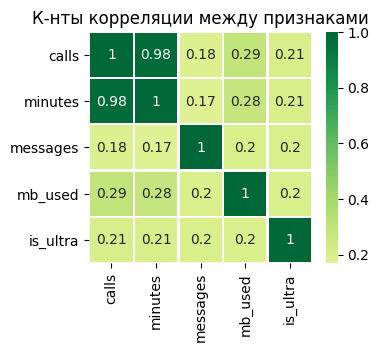

In [17]:
plt.figure(figsize=(3.6,3))
sns.heatmap(data.corr().round(2), annot=True, cmap='RdYlGn', linewidth=1, center= 0)
plt.title('К-нты корреляции между признаками'); plt.show()

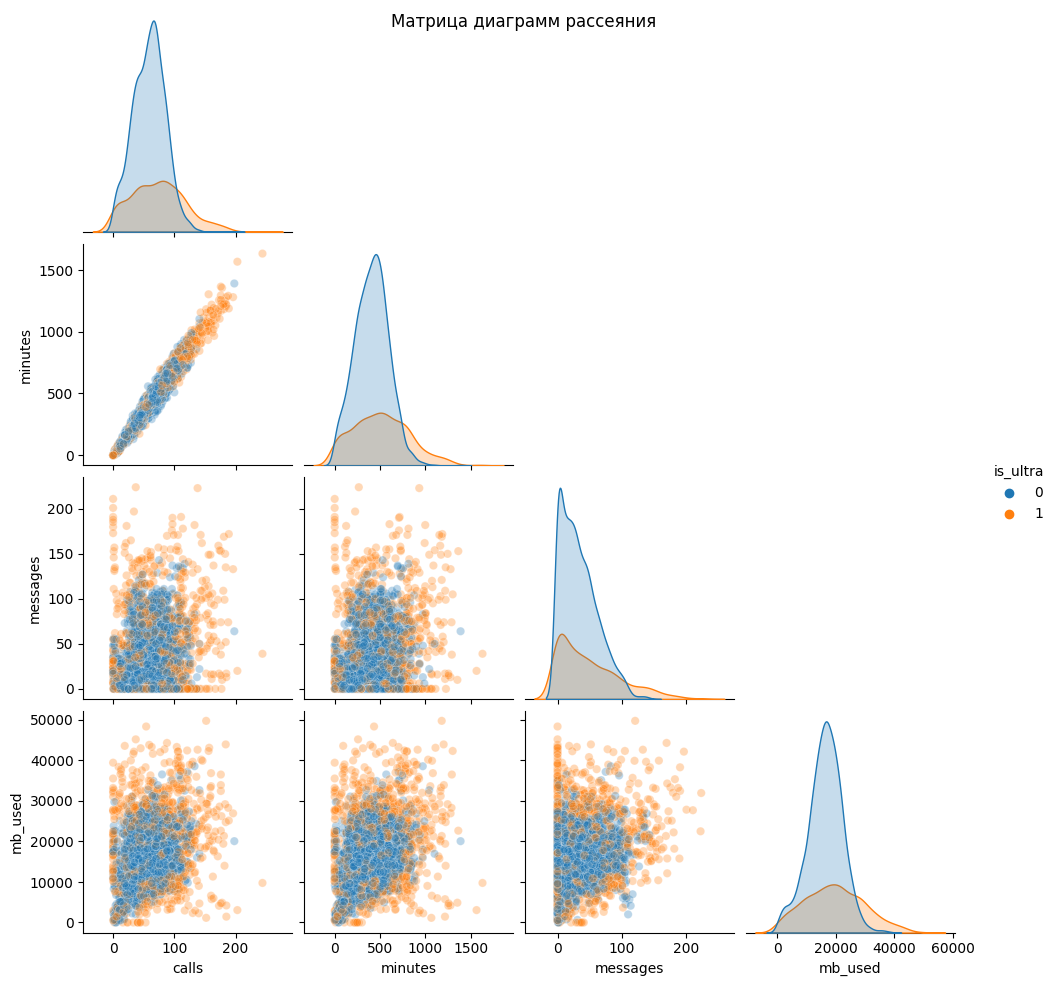

In [18]:
ax=sns.pairplot(data,hue='is_ultra',corner=True,plot_kws=dict(alpha=0.3))
ax.fig.suptitle('Матрица диаграмм рассеяния'); plt.show()

### Вывод по данным

1.  количество объектов - 3214; пропусков нет, целевой признак - категориальный (в том числе, тариф Смарт - 2229 шт.(69%), тариф Ультра - 985 шт.(31%));
2. признаки 'calls' и 'messages' переведены из типа 'float' в 'int';
3. медианы кол-ва звонков, минут, сообщений, трафика у абонентов Ультра выше чем у абоненнтов Смарт соответственно на: 23%, 22%, 36%, 17%;
4. стандартное отклонение характеристик у абонентов Ультра выше чем у абонентов Смарт в среднем на 69%;
5. наблюдается практически полная (0.98) положительная взаимосвязь между количеством звонков и общей продолжительностью разнговоров (что логично);
6. к-нт корреляции Пирсона между тарифом и другими признаками очень слабый (0.2); хотя "ящики с усами" явно отличаются по длине  у разных тарифов; то есть зависимость есть, но носит более сложный нелинейный характер.

## Разбитие данных на выборки

Данные разбиваются на обучающую (60%), валидационную (20%) и тестовую (20%).

In [19]:
features = data.drop('is_ultra',axis=1) # переменная с признаками
target   = data['is_ultra']             # переменная с целевым признаком

In [20]:
# разбитие признаков и целевых признаков на обучающие (60%) и проверочные (40%)
features_train,features_valid_test,target_train,target_valid_test = train_test_split(features,target,test_size=0.4,
                                                                                     random_state=12345,stratify=target)
# разбитие проверочных признаков (в т.ч. целевых) на валидационные (20%) и тестовые (20%)
features_valid,features_test,target_valid,target_test = train_test_split(features_valid_test,target_valid_test,test_size=0.5,
                                                                         random_state=12345,stratify=target_valid_test)

In [21]:
print('features_train (обучающая выборка из признаков, размер):      ', features_train.shape)
print('target_train (обучающая выборка из целевого признака, размер):', target_train.shape)

features_train (обучающая выборка из признаков, размер):       (1928, 4)
target_train (обучающая выборка из целевого признака, размер): (1928,)


In [22]:
print('features_valid (валидационная выборка из признаков, размер):      ', features_valid.shape)
print('target_valid (валидационная выборка из целевого признака, размер):', target_valid.shape)

features_valid (валидационная выборка из признаков, размер):       (643, 4)
target_valid (валидационная выборка из целевого признака, размер): (643,)


In [23]:
print('features_test (тестовая выборка из признаков, размер):      ', features_test.shape)
print('target_test (тестовая выборка из целевого признака, размер):', target_test.shape)

features_test (тестовая выборка из признаков, размер):       (643, 4)
target_test (тестовая выборка из целевого признака, размер): (643,)


## Исследование моделей

### Дерево решений

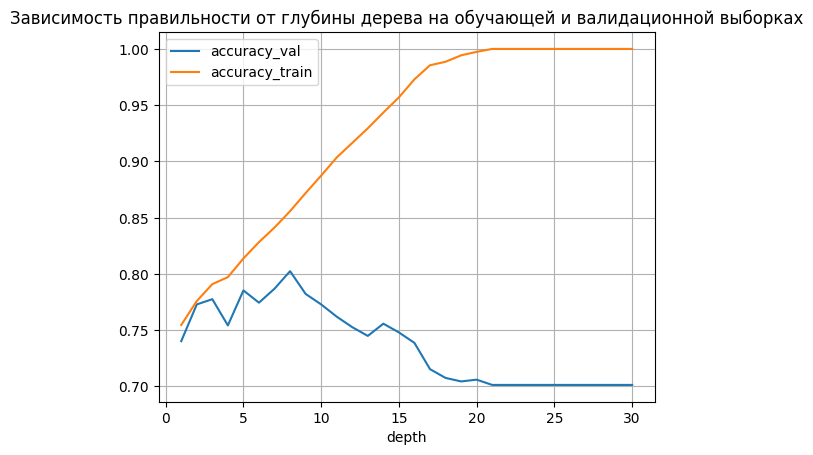

Наибольшая правильность модели дерева решений равна 0.80  и достигается при глубине 8.


In [24]:
DTC_result = []
for depth in range (1,31):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train,target_train)
    accuracy_tr = model.score(features_train,target_train)
    accuracy_v  = model.score(features_valid,target_valid)
    DTC_result.append([depth,accuracy_v,accuracy_tr])
    
DTC_result = pd.DataFrame(DTC_result,columns=['depth','accuracy_val','accuracy_train'])
DTC_result.set_index('depth',inplace=True)
DTC_result.plot(grid=True, title='Зависимость правильности от глубины дерева на обучающей и валидационной выборках')
plt.show()
print(f"Наибольшая правильность модели дерева решений равна {DTC_result['accuracy_val'].max():.2f}\
  и достигается при глубине {DTC_result['accuracy_val'].idxmax()}.")

### Случайный лес

In [25]:
accuracy_best = 0
for depth in range(1,10):
    for est in range(1,101,10):
        model = RandomForestClassifier(random_state=12345,max_depth=depth,n_estimators=est)
        model.fit(features_train,target_train)
        accuracy = model.score(features_valid,target_valid)
        if accuracy > accuracy_best:
            accuracy_best, depth_best, n_estimators_best = accuracy, depth, est
print(f'Наибольшая правильность модели случайного леса равна {accuracy_best:.2f}. Достигается при глубине дерева {depth_best} \
и кол-ве деревьев {n_estimators_best}.')

Наибольшая правильность модели случайного леса равна 0.82. Достигается при глубине дерева 9 и кол-ве деревьев 41.


### Логистическая регрессия

In [26]:
model = LogisticRegression(random_state=12345,solver='lbfgs',max_iter=1000)
model.fit(features_train,target_train)
print(f'Правильность модели логистической регрессии равна {model.score(features_valid,target_valid):.2f}.')

Правильность модели логистической регрессии равна 0.74.


### Вывод по исследованию моделей:

* Наиболее высокую правильность (0.82) показала модель случайного леса при глубине деревьев - 9 и количестве деревьев - 41. Скорость работы данной модели ниже, чем у остальных (но при подобранных гипермараметрах некритично).
* Модель дерева решений показала хорошую правильность (0.80) при глубине дерева - 8 и при высокой скорости выполнения.
* Логистическая регрессия дала самую низкую правильность (0.74) вероятно из-за неверно подобранных гиперпараметров.

## Проверка модели на тестовой выборке

Гиперпараметры подобраны и валидационная выборка нам не нужна.\
Обучим модель на большой выборке (обучающая + валидационная), а тестирование новой модели произведём уже на тестовой выборке.

In [27]:
features_train_valid = pd.concat([features_train,features_valid]) # объединение обучающих признаков с валидационными
target_train_valid   = pd.concat([target_train,target_valid])     # объединение обучающих целивых признаков с валидационными

In [28]:
model_RFC = RandomForestClassifier(random_state=12345,max_depth=9,n_estimators=41)
model_RFC.fit(features_train_valid,target_train_valid)
print(f'Правильность валидированной модели случайного леса на тестовой выборке \
 - {model_RFC.score(features_test,target_test):.2f}.')

Правильность валидированной модели случайного леса на тестовой выборке  - 0.83.


Тестирование модели пройдено. В продакшен необходимо отдавать обученную модель "Случайный лес" при глубине деревьев - 9 и количестве деревьев - 41.

## Проверка моделей на адекватность

Необходимо сравнить модели со случайной моделью, в которой исход случаен. Адекватной признаётся модель, в которой правильность выше правильности случайной модели. \
$$
accuracy = \frac{количество\ правильных\ ответов}{общее\ число\ ответов}\\
accuracy = \frac{a*S*(1-p) + b*S*p}{S}\\
accuracy = a*(1-p) + b*p\\
$$
где a - доля "0" в выборке, b - доля "1" в выборке, p - вероятность модели угадать "1", S - число объектов в выборке.


### Вариант 1 (50/50)

Случайная модель будет делать предсказание Ультра-тарифа ("1") с вероятностью 50%. \
accuracy = a\*(1-0.5) + b\*0.5 = a\*0.5 + b\*0.5 = 0.5\*(a+b) = 0.5

Соответственно правильность моделей выше правильности случайной модели "50/50".

Проверим также данную случайную модель программно. Предскажем целевой признак для тестовой выборки и посчитаем правильность (10 раз для отличающихся предсказаний):

In [29]:
for i in range(10):
    print(round(accuracy_score(target_test, [random.randint(0,1) for j in range(target_test.shape[0])]), 2))

0.49
0.49
0.5
0.52
0.5
0.51
0.5
0.5
0.49
0.46


Адекватность моделей подтвердилась и тестом.

### Вариант 2 (p = b)

Случайная модель будет делать предсказание Ультра-тарифа ("1") с вероятностью равной доле этого тарифа в обучающей целевой выборке. \
$p = b$ \
$accuracy = a*(1-b) + b*b = (1-b)*(1-b)+b*b = 2*b^2 - 2*b + 1$

In [30]:
b = target_train.mean() # доля Ультра в обучающей целевой выборке
print ('p = b =   ',b.round(2))
print ('accuracy =',(2*b**2-2*b+1).round(2))

p = b =    0.31
accuracy = 0.57


Соответственно правильность моделей выше правильности случайной модели "p=b".

Проверим также данную случайную модель программно. Предскажем целевой признак для тестовой выборки и посчитаем правильность:

In [31]:
for i in range(10):
    print(round(accuracy_score(target_test, random.choices([0,1],weights=((1-b),b),k=target_test.shape[0])),2))

0.57
0.59
0.57
0.57
0.56
0.58
0.57
0.6
0.55
0.54


Адекватность моделей подтвердилась и тестом.

### Вариант 3 (mode)

Проверим точность модели всегда предсказывающей самый популярный ответ. В нашем случае это "0".

$p = 0$ \
$accuracy = (1-b)*(1-0) + b*0 = 1-b = 1-0.31 = 0.69$

Проверим также данную случайную модель программно.

In [32]:
round(accuracy_score(target_test, [0]*len(target_test)),2)

0.69

Очень высокая правильность для модели самого популярного ответа (0.69), но модель случайного леса имеет более высокую правильность - 0.82. \
Адекватность модели случайного леса подтвердилась.

#### DummyClassifier

In [33]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
round(dummy_clf.score(features_test, target_test), 2)

0.69

## Вывод

1. Проведён анализ данных. Количество объектов - 3214; пропусков нет, целевой признак - категориальный.
2. Медианы кол-ва звонков, минут, сообщений, трафика у абонентов Ультра выше чем у абоненнтов Смарт в среднем на 25%.
3. Стандартное отклонение характеристик у абонентов Ультра выше чем у абонентов Смарт в среднем на 69%.
4. Изучено 3 модели с подбором гиперпараметров для получения лучшей правильности на валидационной выборке и конечной проверке на тестовой выборке:\
\* Дерево решений -          0.80 ;\
\* Случайный лес -           0.82 / 0.83 (на тестовой выборке);\
\* Логистическая регрессия - 0.74 .
5. Модель удовлетворяет адекватности (правильность выше случайной и популярной).
6. В производство рекомендуется запустить модель Случайный лес с глубиной деревьев - 9 и количеством деревьев - 41.